In [16]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
data = pd.read_excel('/content/drive/MyDrive/2025_1_Colab/DeepLearning/Lib/midtest/mid_exam_2.xlsx')
data.head()

,채취주,year,검출률,평균기온,최저기온,최고기온,일강수량,최소상대습도,평균상대습도
0,1,2011,0.375000,-6.075135,-11.153327,-0.494456,0.136946,41.417186,61.762452
1,2,2011,0.280543,-4.076392,-8.818525,0.718647,0.105141,42.122890,62.366355
2,3,2011,0.227799,-5.670314,-10.527628,-0.600065,0.248654,29.977474,51.005250
3,4,2011,0.281481,-6.593921,-11.180894,-1.482625,0.044444,30.355850,51.509445
4,5,2011,0.225705,-6.156445,-10.095602,-1.625197,0.456338,33.448054,53.131842


In [4]:
data.columns

Index(['채취주', 'year', '검출률', '평균기온', '최저기온', '최고기온', '일강수량', '최소상대습도',
       '평균상대습도'],
      dtype='object')

In [6]:
features = ['채취주', 'year', '평균기온', '최저기온', '최고기온', '일강수량', '최소상대습도', '평균상대습도']
x = data.loc[:,features]
y = data[['검출률']]

x_max = x.max()
y_max = y.max()
x_min = x.min()
y_min = y.min()

x_s = (x-x_min)/(x_max-x_min)
y_s = (y-y_min)/(y_max-y_min)

In [7]:
window_size = 3

In [13]:
def make_dataset(x_data, y_data, window_size):
  x_list = []
  y_list = []
  for i in range(len(x_data) - window_size):
    x_list.append(np.array(x_data.iloc[i:i+window_size]))
    y_list.append(np.array(y_data.iloc[i+window_size]))
  x_list = torch.Tensor(np.array(x_list))
  y_list = torch.Tensor(np.array(y_list)).view(-1)
  return x_list,y_list

x_w, y_w = make_dataset(x_s, y_s, window_size)

In [19]:
start_year = 2011
pred_year = 2016

train_num = 12*(pred_year - start_year) - window_size
x_train = x_w[:train_num].to(device)
x_test = x_w[train_num:].to(device)
y_train = y_w[:train_num].to(device)
y_test = y_w[train_num:].to(device)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16)

for x_data, y_data in train_loader:
  break
print(x_data.shape)
print(y_data.shape)

torch.Size([16, 3, 8])
torch.Size([16])


In [24]:
class RNN(nn.Module):
  def __init__(self):
    super(RNN, self).__init__()
    self.rnn = nn.RNN(input_size= len(features), hidden_size=16, num_layers=5, batch_first=True)
    self.fc1 = nn.Linear(in_features=window_size*16, out_features=10)
    self.fc2 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    h0 = torch.zeros(5, x.size(0), 16).to(device)
    x, hn = self.rnn(x, h0)
    x = x.reshape(x.size(0), -1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = x.reshape(-1)
    return x

In [25]:
torch.cuda.manual_seed(42)
model = RNN()
model.to(device)
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_train_record = []
loss_test_record = []

num_epochs = 1000

In [27]:
for epoch in range(num_epochs):
  for x_data, y_data in train_loader:
    optimizer.zero_grad()

    outputs = model(x_data)
    loss_train = nn.MSELoss()(outputs, y_data)

    loss_train.backward()
    optimizer.step()

  outputs_train = model(x_train)
  loss_train = nn.MSELoss()(outputs_train, y_train)
  outputs_test = model(x_test)
  loss_test = nn.MSELoss()(outputs_test, y_test)
  loss_train_record.append(loss_train.item())
  loss_test_record.append(loss_test.item())

  if epoch % 10 == 0:
    print(f'epoch: {epoch}, loss_train: {loss_train:.5f}, loss_test: {loss_test:.2f}')

epoch: 0, loss_train: 0.00017, loss_test: 0.05
epoch: 10, loss_train: 0.00017, loss_test: 0.05
epoch: 20, loss_train: 0.00022, loss_test: 0.05
epoch: 30, loss_train: 0.00016, loss_test: 0.05
epoch: 40, loss_train: 0.00018, loss_test: 0.05
epoch: 50, loss_train: 0.00020, loss_test: 0.05
epoch: 60, loss_train: 0.00023, loss_test: 0.05
epoch: 70, loss_train: 0.00046, loss_test: 0.05
epoch: 80, loss_train: 0.00025, loss_test: 0.05
epoch: 90, loss_train: 0.00016, loss_test: 0.05
epoch: 100, loss_train: 0.00015, loss_test: 0.05
epoch: 110, loss_train: 0.00015, loss_test: 0.05
epoch: 120, loss_train: 0.00016, loss_test: 0.05
epoch: 130, loss_train: 0.00016, loss_test: 0.05
epoch: 140, loss_train: 0.00015, loss_test: 0.05
epoch: 150, loss_train: 0.00015, loss_test: 0.05
epoch: 160, loss_train: 0.00016, loss_test: 0.05
epoch: 170, loss_train: 0.00016, loss_test: 0.05
epoch: 180, loss_train: 0.00015, loss_test: 0.05
epoch: 190, loss_train: 0.00016, loss_test: 0.05
epoch: 200, loss_train: 0.00014

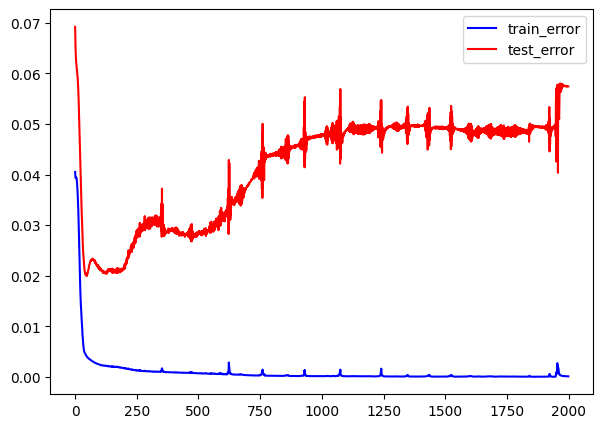

In [28]:
plt.figure(figsize=(7,5))
plt.plot(loss_train_record, 'b', label='train_error')
plt.plot(loss_test_record, 'r', label='test_error')
plt.legend()
plt.show()

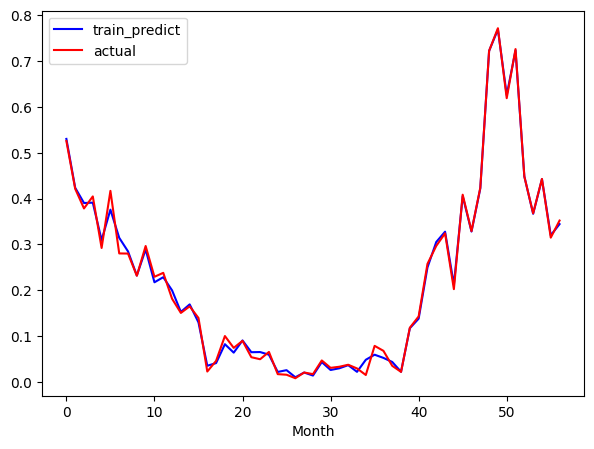

In [29]:
plt.figure(figsize=(7,5))
plt.plot(outputs_train.to('cpu').detach(), 'b', label='train_predict')
plt.plot(y_train.to('cpu'), 'r', label='actual')
plt.xlabel('Month')
plt.legend()
plt.show()

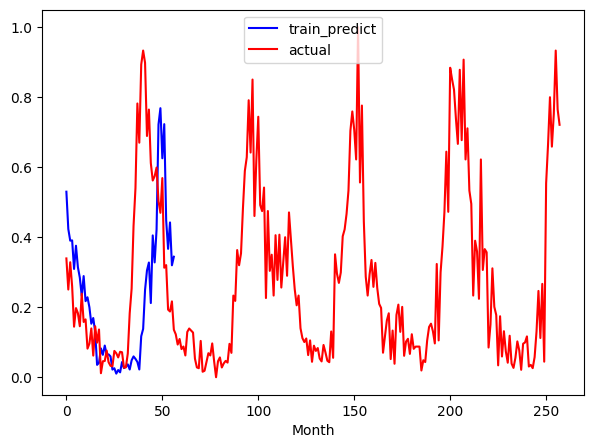

In [30]:
plt.figure(figsize=(7,5))
plt.plot(outputs_train.to('cpu').detach(), 'b', label='train_predict')
plt.plot(y_test.to('cpu'), 'r', label='actual')
plt.xlabel('Month')
plt.legend()
plt.show()

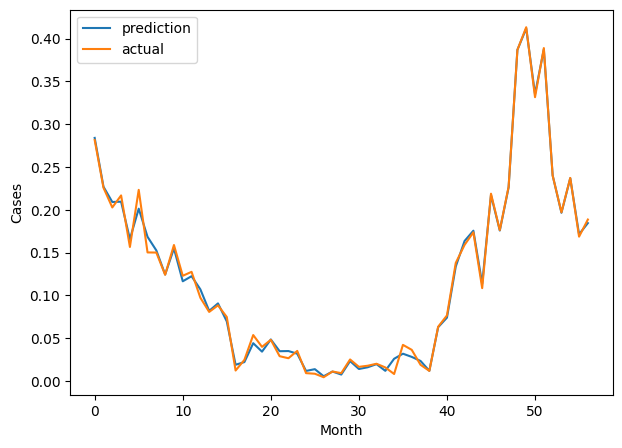

In [41]:
plt.figure(figsize = (7,5))
plt.plot(torch.Tensor([y_max.item()-y_min.item()])*outputs_train.to('cpu').detach()+torch.Tensor([y_min.item()]), label='prediction')
plt.plot(torch.Tensor([y_max.item()-y_min.item()])*y_train.to('cpu')+torch.Tensor([y_min.item()]), label = 'actual')
plt.xlabel('Month')
plt.ylabel('Cases')
plt.legend()
plt.show()

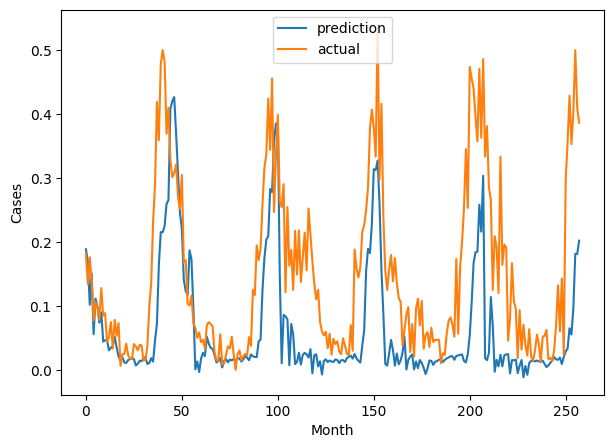

In [42]:
plt.figure(figsize = (7,5))
plt.plot(torch.Tensor([y_max.item()-y_min.item()])*outputs_test.to('cpu').detach()+torch.Tensor([y_min.item()]), label='prediction')
plt.plot(torch.Tensor([y_max.item()-y_min.item()])*y_test.to('cpu')+torch.Tensor([y_min.item()]), label = 'actual')
plt.xlabel('Month')
plt.ylabel('Cases')
plt.legend()
plt.show()